# Init Tdx 

In [177]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

'module://ipympl.backend_nbagg'

In [178]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [179]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [180]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(7.35, '2024-07-18')

(8.75,
 52    2024-10-09
 Name: date, dtype: object)

9 0.2 1.79
Bull
1.79


### regression_line(X, Y)
regression_ratio(df, window=10):

7.07 0.01
Above
0.01


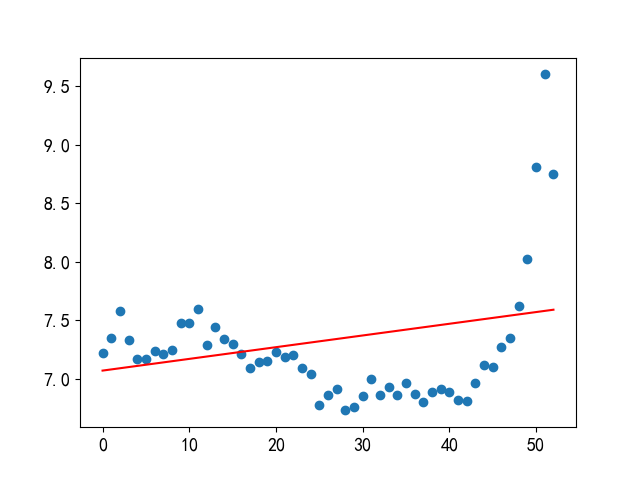

In [181]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

7.07 0.01
Above
0.01


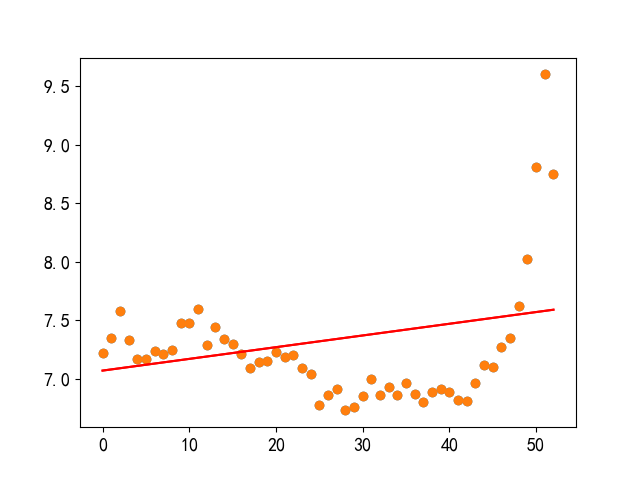

In [182]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [183]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'max5', 'hmax', 'high4', 'low4', 'lastdu4', 'lmin', 'min5', 'cmean',
       'hv', 'lv'],
      dtype='object', length=183)

### check_postion_vol_price

In [184]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code  open  high   low  close          vol        amount  \
52  2024-10-09  601360  9.38  9.38  8.72   8.75  220531349.0  2.000263e+09   

    ma5d  ma10d  ...  hmax  high4  low4  lastdu4  lmin  min5  cmean  \
52  8.56   7.86  ...  7.62   9.69  7.31     1.33  6.57  7.31   7.24   

             hv          lv  Positon  
52  120682499.0  18501628.0  Neutral  

[1 rows x 184 columns]

In [185]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'hmax', 'high4', 'low4', 'lastdu4', 'lmin', 'min5', 'cmean', 'hv', 'lv',
       'Positon'],
      dtype='object', length=184)

0    2024-07-18
1    2024-07-19
2    2024-07-22
Name: date, dtype: object

52   2024-10-09
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:0.01 
code: 601360


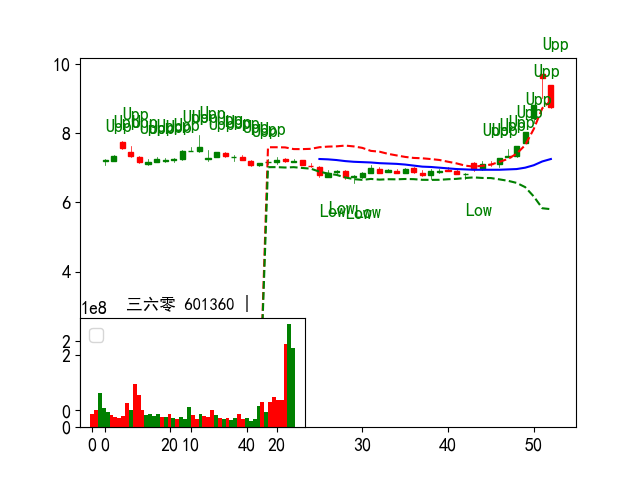

In [186]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    print("code:",code)
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [187]:
'code' in dfc.columns

True

### show_channel_mpl

In [188]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [189]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None):
    col_src = [
        "name", "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name]
    return temp


def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [190]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.02,
        ma_250_h=1.11, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().market('all').index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    # df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20150501', end=None, freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration(
        h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
        freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)

    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [191]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.02,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 4926
0.61 (4869,) 688168 (281, 6)
resample:D
use time:12.25


In [192]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high   low  close          vol        amount
date                                                          
2024-09-30  9.72  9.72  9.27   9.72  579726570.0  5.592762e+09

### Test InStock

In [193]:
df.loc['301083'][:2]

open   high    low  close        vol      amount
date                                                         
2023-08-04  16.92  17.30  16.81  17.08  3852130.0  66165548.0
2023-08-07  17.08  17.41  16.98  17.22  4029700.0  70028720.0

## ra_diff

In [194]:
tail_days = 60

In [195]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [196]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [197]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [198]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [199]:
# df.loc['000002'][-10:]

## sina_dm

In [200]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2024-10-09',
 code
 603678    火炬电子
 Name: name, dtype: object)

In [201]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2024-10/10/24 09:46:24'

code
603306   2024-10-10 09:46:15
300693   2024-10-10 09:46:15
Name: ticktime, dtype: datetime64[ns]

0.1502600868542989

### Combine ratio and idx

In [202]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [203]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df

In [204]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
h5code='603019'
h5.loc[h5code][-3:]
code_muti = '603019'
# h5.loc[code_muti][:2]

freq = 'D'
# freq = '5M'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()
time_ratio
run_col = ['close', 'volume']
# run_col = ['close']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol = round(allvol / 10 / 1000 / 1000,2)
print("总量:%s 亿"%(allvol))
mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
#全局占比
mdf['volume'] = mdf.amount.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
mdf=mdf.reset_index().set_index('code')
mdf.loc[h5code]

['/all_20']
G:\sina_MultiIndex_data.h5


(162458, 6)

close  high   low  llastp    volume  lastbuy
ticktime                                                         
2024-10-10 09:45:39  54.45  56.5  50.4   55.95  41620149    54.45
2024-10-10 09:46:15  53.97  56.5  50.4   55.95  42366924    56.00
2024-10-10 09:46:15  53.97  56.5  50.4   55.95  42366924    56.00

0.171

总量:4250.89 亿


ticktime    2024-10-11 00:00:00
close                 53.826061
volume                     3.14
vol                       42.37
amount                     22.8
Name: 603019, dtype: object

In [205]:
mdf[:2]
mdf.loc['603019']

ticktime      close  volume     vol  amount
code                                                
000001 2024-10-11  11.816667    1.19   73.13    8.64
000002 2024-10-11   8.941515    1.62  131.29   11.74

ticktime    2024-10-11 00:00:00
close                 53.826061
volume                     3.14
vol                       42.37
amount                     22.8
Name: 603019, dtype: object

In [206]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
str(h5.index.get_level_values(1)[-1])[:10]

'2024-10-10'

In [207]:
if len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2024-10-11 00:00:00
close                  8.941515
volume                     1.62
vol                      131.29
amount                    11.74
Name: 000002, dtype: object

###  实时成交量个股Top

In [208]:
nowdf = mdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
# top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd=get_sina_data_cname(top20_nd)

In [209]:
nowdf.shape,top20_nd

((4850, 5),
         volume   name
 code                 
 300059   25.20   东方财富
 601162   13.84   天风证券
 300339   10.86   润和软件
 600030    9.70   中信证券
 000158    7.88   常山北明
 688981    7.35   中芯国际
 300077    6.72   国民技术
 300085    4.97    银之杰
 301236    4.16   软通动力
 300750    4.04   宁德时代
 601318    3.75   中国平安
 002261    3.66   拓维信息
 300033    3.64    同花顺
 600519    3.59   贵州茅台
 600570    3.37   恒生电子
 000858    3.33  五 粮 液
 600460    3.29    士兰微
 000750    3.22   国海证券
 300803    3.19    指南针
 603019    3.14   中科曙光)

### 合并实时成交量及SinaDM

In [210]:
# mdf[:1]
sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
sinadm[:1]

name   open  llastp    now  trade   high    low    buy   sell  \
code                                                                    
603678  火炬电子  25.88   25.88  26.28    0.0  26.44  25.88  26.23  26.28   

         volume  ...  close     nvol         timel  lastbuy   nlow  nhigh  \
code             ...                                                        
603678  1585900  ...  26.28  1585900  1.728525e+09    25.88  25.88  26.44   

        nclose  nstd   vol  amount  
code                                
603678   26.19  -2.0  1.59    0.42  

[1 rows x 44 columns]

## check HDF LastDate

In [211]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(0, 7)

(4869, 7)

In [212]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open       high       low      close           vol  \
code   date                                                                  
999999 2024-09-30  3194.7224  3358.5883  3153.697  3336.4974  1.102338e+09   

                         amount  ra_diff  
code   date                               
999999 2024-09-30  1.167773e+12     1.23

In [213]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [214]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [215]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [216]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [217]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper   low  boll
date                                
2024-09-27   8.63   8.41  8.39  7.88
2024-09-30   9.34   8.79  8.73  7.95

open  high   low  close         vol       amount  ra_diff  ma10  \
date                                                                          
2024-09-26  8.05  8.34  8.02   8.34  10286768.0   84511616.0     1.11  7.78   
2024-09-27  8.53  8.65  8.39   8.63  12060920.0  103047225.0     1.15  7.88   

             ma5  ma20  ...  perc2d  perc3d  perc4d  perc5d  vol1d  vol2d  \
date                    ...                                                 
2024-09-26  7.94  7.85  ...    5.04    8.74    8.59    8.31 -14.90  42.35   
2024-09-27  8.13  7.88  ...    6.94    8.69   12.52   12.37  17.25 -14.90   

             vol3d   vol4d  vol5d  volsum5d  
date                                         
2024-09-26  199.78  -10.49 -43.07     173.7  
2024-09-27   42.35  199.78 -10.49     234.0  

[2 rows x 28 columns]

(60, 28)


In [218]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff     hat   close  volsum5d     hmax     lmin  perc1d  \
date                                                                      
2024-09-27     1.29  360.74  1629.2     130.0  1629.20  1245.83    6.55   
2024-09-30     1.39  487.82  1748.0     194.9  1759.88  1245.83    7.29   

               ma20   ma250  vol1d  vol2d  vol3d   vol4d   vol5d  perc3d  \
date                                                                       
2024-09-27  1380.99  345.98  -9.62  31.54 -26.35  120.45   13.93   18.69   
2024-09-30  1397.72  352.93  78.90  -9.62  31.54  -26.35  120.45   24.95   

            perc5d    ma51d  ra_diff  
date                                  
2024-09-27   28.90  1438.27     1.29  
2024-09-30   38.56  1535.56     1.39

### Append Now SinaTo MultiIndex dfNow

In [219]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfsRoot=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days),sinadm)
    dfNow= dfsRoot.groupby(level=[0]).tail(tail_days/2)
    
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

concat1 init:sina_today:603678
concat1:sina_today:603678 2024-10-10 00:00:00


open   high    low  close           vol        amount  \
code   date                                                                 
000001 2024-09-30  11.62  12.30  11.56  12.21  5.430284e+08  6.467439e+09   
       2024-10-10  11.62  11.98  11.61  11.90  7.313000e+01  8.640000e+00   

                   ra_diff   ma10    ma5   ma20  ...  perc4d  perc5d   vol1d  \
code   date                                      ...                           
000001 2024-09-30     1.27  10.49  11.13  10.23  ...   17.74   21.61   41.41   
       2024-10-10      NaN  10.71  11.44  10.31  ...   13.33   14.75 -100.00   

                   vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  name  
code   date                                                           
000001 2024-09-30  24.42  42.85  31.89  82.65     223.2  11.13   NaN  
       2024-10-10  41.41  24.42  42.85  31.89      40.6    NaN  平安银行  

[2 rows x 30 columns]

In [220]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'][-1:]


open  high   low  close     vol  amount  ra_diff  ma10  ma5  ma20  \
date                                                                            
2024-10-10   8.9  9.18  8.72   8.99  131.29   11.74      NaN   NaN  NaN   NaN   

            ...  perc4d  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  \
date        ...                                                                
2024-10-10  ...     NaN     NaN    NaN    NaN    NaN    NaN    NaN       NaN   

            ma51d  name  
date                     
2024-10-10    NaN  万 科Ａ  

[1 rows x 30 columns]

### Xratio and tail 60 MultiIndex 

In [221]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [222]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open   high    low  close         vol        amount  ra_diff  \
date                                                                       
2024-07-05  39.3  40.38  39.22  39.68  29051640.0  1.155065e+09     1.16   

            ma10    ma5  ma20  ...  perc4d  perc5d  vol1d   vol2d  vol3d  \
date                           ...                                         
2024-07-05  9.88  13.49   8.1  ...  504.88   511.4  94.17  315.85   23.7   

            vol4d  vol5d  volsum5d  ma51d  name  
date                                             
2024-07-05  -4.25  27.87     457.3  13.49   NaN  

[1 rows x 30 columns]

## DFNow Query check

In [223]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2024-10-09


Series([], Name: xratio, dtype: float64)

date
2024-09-20     NaN
2024-09-23    0.05
2024-09-24    0.06
2024-09-25    0.05
2024-09-26    0.06
2024-09-27    0.07
2024-09-30    0.11
2024-10-10    0.14
Name: close, dtype: float64

In [224]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2024-09-30    4.24
2024-10-10     NaN
Name: upper, dtype: float64

(60, 30)
xratio:0.01 ra_diff:nan
code: 300459


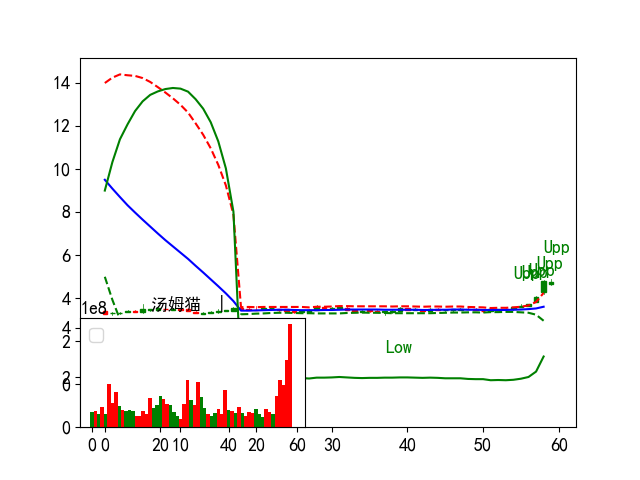

In [225]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

300059 date
2024-09-30    2.04
2024-10-10     NaN
Name: ra_diff, dtype: float64
xratio:0.06 ra_diff:nan
code: 300059


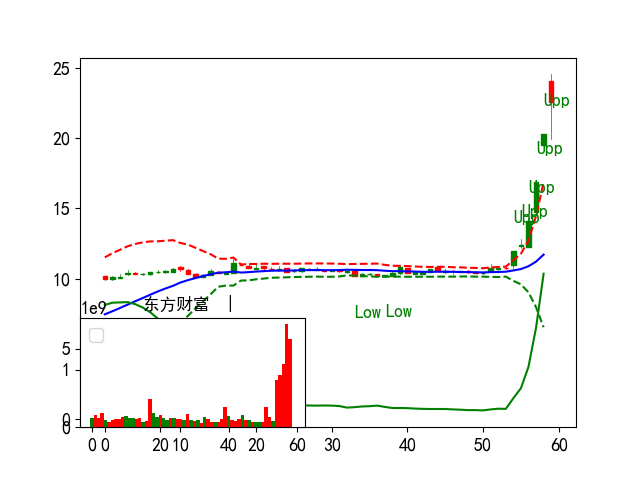

601162 date
2024-09-30    2.06
2024-10-10     NaN
Name: ra_diff, dtype: float64
xratio:0.02 ra_diff:nan
code: 601162


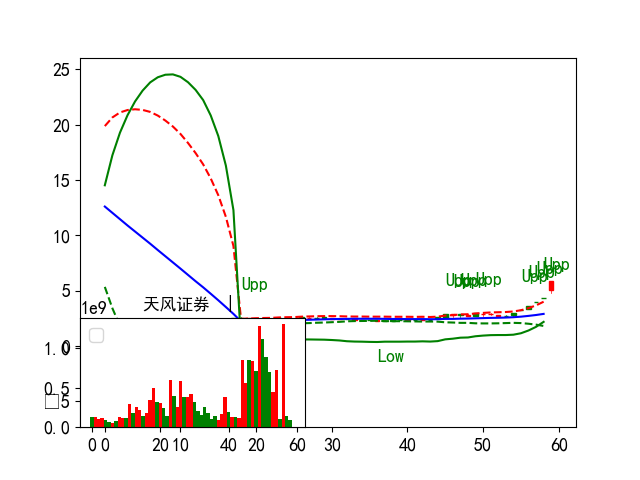

In [226]:
for co in top20_nd.index[:2]:
    print(co,dfNow.loc[co].ra_diff[-2:])
    # show_ohlc_upper(dfs.loc[co][-30:],co)
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)

In [227]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date  open   high    low  close    vol  amount  ra_diff   ma10  \
code                                                                          
689009 2024-10-10  53.0  54.97  52.95  54.00   3.26    1.76      NaN  43.28   
688981 2024-10-10  85.1  86.35  70.01  77.97  67.95   53.43      NaN  49.82   

          ma5  ...  vol1d   vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  name  \
code           ...                                                              
689009  43.62  ... -100.0   -3.16  22.86  52.83 -44.14     -71.6    NaN  九号公司   
688981  55.84  ... -100.0  265.58  14.88   5.08  15.61     201.1    NaN  中芯国际   

        xratio    idx  
code                   
689009   -0.18   8.62  
688981    0.39  34.80  

[2 rows x 33 columns]

In [228]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [229]:
df.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff
date                                                                   
2024-09-27  8.52  8.84  8.50   8.84  700219385.0  6.084951e+09     1.42
2024-09-30  9.72  9.72  9.27   9.72  579726570.0  5.592762e+09     1.56

In [230]:
dfNow.loc['000002'][-2:]

open  high   low  close           vol        amount  ra_diff  \
date                                                                       
2024-09-30  9.72  9.72  9.27   9.72  5.797266e+08  5.592762e+09     1.56   
2024-10-10  8.90  9.18  8.72   8.99  1.312900e+02  1.174000e+01      NaN   

            ma10   ma5  ma20  ...   vol1d  vol2d  vol3d  vol4d   vol5d  \
date                          ...                                        
2024-09-30  7.44  8.21  6.95  ...  -17.21  32.66  34.13  21.30  112.07   
2024-10-10  7.71  8.58  7.06  ... -100.00 -17.21  32.66  34.13   21.30   

            volsum5d  ma51d  name  xratio  idx  
date                                            
2024-09-30     182.9   8.21   NaN    0.09  3.4  
2024-10-10     -29.1    NaN  万 科Ａ    0.10  2.5  

[2 rows x 32 columns]

# 基础处理

In [231]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2024-09-18 2024-10-09


open   high    low  close           vol        amount  \
code   date                                                                 
000001 2024-09-30  11.62  12.30  11.56  12.21  5.430284e+08  6.467439e+09   
       2024-10-10  11.62  11.98  11.61  11.90  7.313000e+01  8.640000e+00   

                   ra_diff   ma10    ma5   ma20  ...   vol1d  vol2d  vol3d  \
code   date                                      ...                         
000001 2024-09-30     1.27  10.49  11.13  10.23  ...   41.41  24.42  42.85   
       2024-10-10     0.00  10.71  11.44  10.31  ... -100.00  41.41  24.42   

                   vol4d  vol5d  volsum5d  ma51d  name  xratio   idx  
code   date                                                           
000001 2024-09-30  31.89  82.65     223.2  11.13     0    0.03  2.51  
       2024-10-10  42.85  31.89      40.6   0.00  平安银行    0.05  2.13  

[2 rows x 32 columns]

Low:2024-09-18


Timestamp('2024-09-18 00:00:00')

In [232]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
        top_temp = top_temp[(~top_temp.index.str.contains(
            '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(8820, 32)
count dd.couts
(code    date      
688568  2024-09-18    9
688498  2024-09-18    9
688399  2024-09-18    9
688279  2024-09-18    9
688155  2024-09-18    9
Name: couts, dtype: int64, (8820, 33))
dt_low:2024-09-18 df:1927 Index(['688568', '688498', '688399', '688279', '688155'], dtype='object', name='code') df_idx:4583
Main Down dd :0 MainUP df:1927 couts std:2.5 
time: 0.09  1438


In [233]:
dfs_dtlen.loc['002987'][-1:]

open  high    low  close    vol  amount  ra_diff  ma10   ma5  \
date                                                                        
2024-10-10  15.71  15.9  14.64  15.06  12.67    1.91      0.0  12.1  13.3   

            ma20  ...  vol1d  vol2d  vol3d  vol4d   vol5d  volsum5d  ma51d  \
date              ...                                                        
2024-10-10  11.4  ... -100.0  11.06   0.06  -21.5  139.55      29.2    0.0   

            name  xratio   idx  
date                            
2024-10-10   京北方    0.12  4.67  

[1 rows x 32 columns]

## 最近60天筛选

In [234]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [235]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(
    df_mask250)[:3]

(985, 32)
count dd.couts
(code    date      
603319  2024-08-22    13
Name: couts, dtype: int64, (985, 33))
(code    date      
603319  2024-09-26    13
603558  2024-09-24    11
Name: couts, dtype: int64, (379, 33))
Count:379 33


name  couts  ra_diff  xratio   idx   hat  close  volsum5d  \
code   date                                                                   
600686 2024-09-27    0      1     1.71   -0.14  0.84  4.25  12.30      26.6   
002829 2024-09-27    0      1     1.53   -0.13  2.08  3.71  18.10      49.8   
603223 2024-09-30    0      2     1.47   -0.01  0.33  1.46   9.04     122.7   

                    hmax   lmin  perc1d   ma20  ma250   vol1d  vol2d  vol3d  \
code   date                                                                   
600686 2024-09-27  15.00  10.70    3.97  12.12  11.61  -34.29  27.46  -12.6   
002829 2024-09-27  19.10  15.15    4.81  16.89  17.45   11.05   3.03    1.5   
603223 2024-09-30   9.14   7.52    9.98   8.50   8.24  180.08   7.07  -33.8   

                   vol4d  vol5d  perc3d  perc5d  
code   date                                      
600686 2024-09-27  12.18  33.90    8.56   12.84  
002829 2024-09-27   2.79  31.45    9.30   12.98  
603223 2024-09-30 -28.35  -2.35   16.05   12.86

#### filter today

In [236]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [237]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [238]:
dfs.loc['301073'][-5:].ra_diff

date
2024-09-25    1.11
2024-09-26    1.29
2024-09-27    1.34
2024-09-30    1.61
2024-10-10    0.00
Name: ra_diff, dtype: float64

xratio:0.01 ra_diff:nan
code: 000002


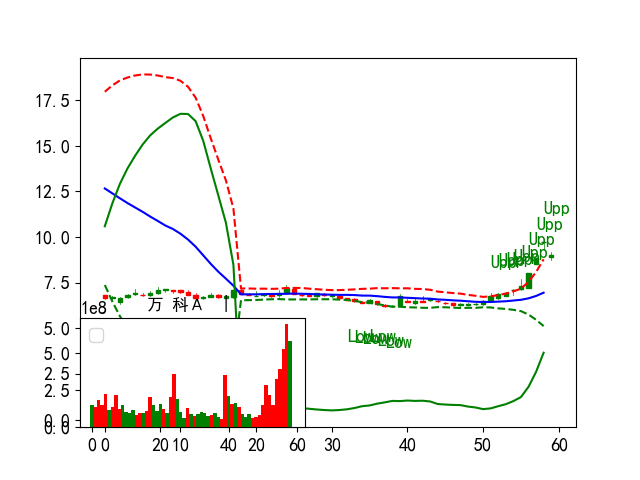

In [239]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [240]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [241]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2024-09-26    1.11
        2024-09-27    1.14
        2024-09-30    1.23
399001  2024-09-26    1.12
        2024-09-27    1.19
        2024-09-30    1.32
399006  2024-08-09    1.00
        2024-09-27    1.18
        2024-09-30    1.36
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [242]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])[-2:]
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 32


name  ra_diff  xratio   idx   hat  close  volsum5d   hmax   lmin  \
date                                                                           
2024-09-30     0     1.29    0.05  3.07  2.76  15.72     152.1  15.88  12.41   
2024-10-10  上海沪工     0.00    0.07  2.71  0.00  15.48      21.1   0.00   0.00   

            perc1d   ma20  ma250  vol1d   vol2d  vol3d  vol4d  vol5d  perc3d  \
date                                                                           
2024-09-30    8.26  13.36  10.52  109.4    0.99 -17.08  27.75  31.07   15.59   
2024-10-10   -1.53  13.46   0.00 -100.0  109.40   0.99 -17.08  27.75   11.85   

            perc5d  
date                
2024-09-30    20.0  
2024-10-10    15.7

## !!! Run-Filter强势Upper

### !!! filterRule test

In [243]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 0.06 0.55


'Bull'

0.55

date
2024-09-25    0.00
2024-09-26    0.00
2024-09-27    0.01
2024-09-30    0.01
2024-10-10    0.02
Name: xratio, dtype: float64

xratio:0.0 ra_diff:nan
code: 601728


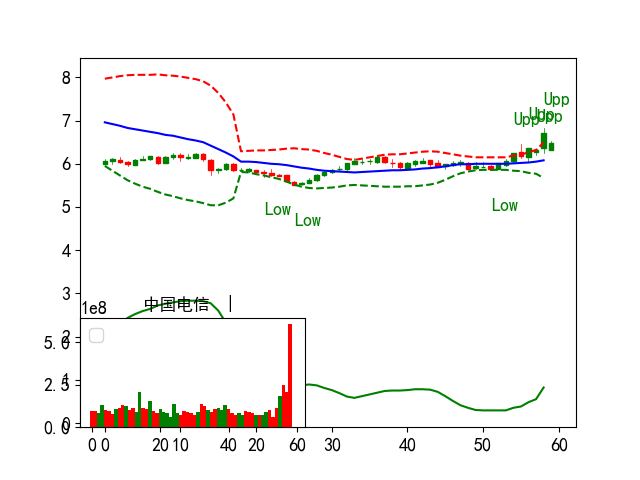

In [244]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [245]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高

30
xratio:0.03 ra_diff:nan
code: 600012


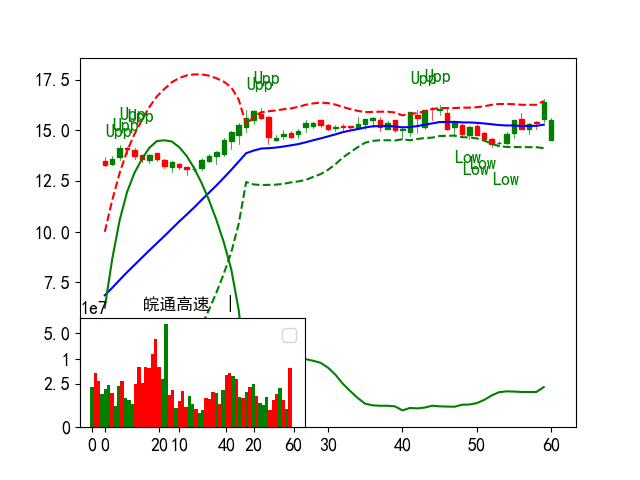

In [246]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

In [247]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)[:10]
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 300866    16
 Name: couts, dtype: int64,
 (1654, 41))

Count:1654 41


name  couts       date  perc  ra_diff  xratio    idx  hat  close  \
code                                                                       
300866  安克创新     16 2024-10-10  7.19      0.0    0.90  23.22  0.0  92.18   
002693  双成药业     15 2024-10-10 -7.58      0.0    0.53  10.67  0.0  18.30   
603380   易德龙     15 2024-10-10  1.44      0.0    0.12   3.95  0.0  24.00   
002595  豪迈科技     15 2024-10-10  3.94      0.0    0.29   5.37  0.0  48.57   
600927  永安期货     15 2024-10-10  0.73      0.0    0.15   2.77  0.0  15.11   
601628  中国人寿     14 2024-10-10 -0.83      0.0    0.37   8.08  0.0  43.20   
002396  星网锐捷     14 2024-10-10  2.05      0.0    0.09   3.32  0.0  16.91   
000651  格力电器     14 2024-10-10  2.90      0.0    0.30   8.80  0.0  49.32   
603991  至正股份     14 2024-10-10  9.78      0.0    0.65  22.58  0.0  65.88   
600718  东软集团     13 2024-10-10  0.19      0.0    0.09   1.87  0.0  10.46   

        volsum5d  ...  ma250  nclose   llow  vol1d   vol2d  vol3d  vol4d  \
code              ...                                                      
300866     -38.0  ...    0.0   90.68  85.90 -100.0   56.60  -6.81  -6.39   
002693    1457.5  ...    0.0   18.22  17.82 -100.0   30.85 -94.12  15.73   
603380     170.9  ...    0.0   23.88  23.58 -100.0  263.03 -23.44 -38.34   
002595      31.5  ...    0.0   48.42  46.60 -100.0   19.29  85.84  12.81   
600927      -7.9  ...    0.0   15.10  14.80 -100.0   91.16 -29.98 -16.02   
601628      67.7  ...    0.0   43.25  42.57 -100.0  183.90 -58.13  16.96   
002396      30.3  ...    0.0   16.82  16.60 -100.0   66.18  76.32  -7.18   
000651      19.5  ...    0.0   49.18  48.17 -100.0   51.99  51.60  -7.06   
603991       5.7  ...    0.0   64.63  60.50 -100.0  119.16 -25.41  52.22   
600718      89.5  ...    0.0   10.44  10.17 -100.0  206.44  -4.22  -2.24   

          vol5d  perc3d  perc5d  
code                             
300866    18.60   31.40   30.75  
002693  1605.07   35.36   63.83  
603380    69.69   14.56   15.38  
002595    13.59   12.15   14.88  
600927    46.94   13.10   16.41  
601628    24.92   10.12   17.39  
002396    -5.03   15.35   18.25  
000651    23.00   11.13   18.90  
603991   -40.31   39.58   53.89  
600718   -10.48   14.69   16.22  

[10 rows x 24 columns]

#### !!! hmax Top upper > 1

In [248]:
# dfs_tail9.loc['600103']

In [249]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['volsum5d', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])

show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1)] )[:10]

count dd.couts
compute percent
code
002423    5
Name: couts, dtype: int64 (1696, 41)


(code
 002423    5
 Name: couts, dtype: int64,
 (1696, 41))

Count:1620 41


name  couts       date   perc  ra_diff  xratio    idx  hat  close  \
code                                                                        
002423  中粮资本      5 2024-10-10  10.01      0.0    0.18   8.47  0.0  15.82   
002693  双成药业     14 2024-10-10  -7.58      0.0    0.53  10.67  0.0  18.30   
600705  中航产融      8 2024-10-10  -6.28      0.0    0.05   0.98  0.0   3.43   
601162  天风证券      8 2024-10-10  -4.71      0.0    0.08   2.19  0.0   5.06   
300140  节能环境      2 2024-10-10   2.08      0.0    0.06   1.91  0.0   6.39   
300834  星辉环材      2 2024-10-10   2.65      0.0    0.05   3.94  0.0  20.51   
300390  天华新能      3 2024-10-10   1.87      0.0    0.19   9.98  0.0  26.11   
300259  新天科技      2 2024-10-10   1.81      0.0    0.02   0.89  0.0   3.37   
300712  永福股份      3 2024-10-10   4.79      0.0    0.12   7.01  0.0  25.39   
301439  泓淋电力      3 2024-10-10   2.51      0.0    0.05   2.68  0.0  13.50   

        volsum5d  ...  ma250  nclose   llow  vol1d   vol2d  vol3d    vol4d  \
code              ...                                                        
002423    1616.6  ...    0.0   15.63  12.94 -100.0  -84.71 -59.18  1919.87   
002693    1457.5  ...    0.0   18.22  17.82 -100.0   30.85 -94.12    15.73   
600705    1094.8  ...    0.0    3.47   3.29 -100.0   15.76 -18.57  1267.40   
601162     876.3  ...    0.0    5.08   4.78 -100.0  -34.72 -89.32  1186.28   
300140     657.1  ...    0.0    6.38   6.26 -100.0   22.82 -35.68    16.68   
300834     545.8  ...    0.0   20.44  20.11 -100.0  396.88  -4.56    54.95   
300390     530.7  ...    0.0   26.10  25.62 -100.0  351.46 -24.96   -16.96   
300259     482.8  ...    0.0    3.37   3.32 -100.0  375.76 -33.95    72.50   
300712     472.5  ...    0.0   25.16  24.70 -100.0  445.41 -22.17    17.14   
301439     470.3  ...    0.0   13.44  13.22 -100.0  435.21  -8.22    65.58   

          vol5d  perc3d  perc5d  
code                             
002423   -59.39   61.10   94.83  
002693  1605.07   35.36   63.83  
600705   -69.82    7.86   30.42  
601162   -85.91   39.39   68.67  
300140   753.24   19.66   41.37  
300834   198.48   20.01   25.29  
300390   321.20   52.78   64.32  
300259   168.45   28.14   35.89  
300712   132.13   32.79   41.45  
301439    77.69   20.21   24.42  

[10 rows x 24 columns]

In [250]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [251]:
show_tdx_data(
    df_mask_hmax.sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')[:20]

Count:1696 41


name  couts       date   perc  ra_diff  ra_diff  xratio    idx  hat  \
code                                                                          
002693  双成药业     14 2024-10-10  -7.58      0.0      0.0    0.53  10.67  0.0   
000651  格力电器     13 2024-10-10   2.90      0.0      0.0    0.30   8.80  0.0   
300409  道氏技术     10 2024-10-10   2.74      0.0      0.0    0.08   3.29  0.0   
600797  浙大网新     10 2024-10-10   2.94      0.0      0.0    0.04   1.29  0.0   
600415  小商品城     10 2024-10-10   1.16      0.0      0.0    0.04   0.99  0.0   
601318  中国平安      9 2024-10-10   3.82      0.0      0.0    0.46  14.13  0.0   
000158  常山北明      9 2024-10-10  10.03      0.0      0.0    0.32   8.43  0.0   
002261  拓维信息      9 2024-10-10   4.50      0.0      0.0    0.25   7.88  0.0   
601633  长城汽车      9 2024-10-10   3.64      0.0      0.0    0.27   6.57  0.0   
600690  海尔智家      9 2024-10-10   2.92      0.0      0.0    0.32   5.94  0.0   
002595  豪迈科技      9 2024-10-10   3.94      0.0      0.0    0.29   5.37  0.0   
002891  中宠股份      9 2024-10-10   1.55      0.0      0.0    0.08   4.62  0.0   
002294   信立泰      9 2024-10-10   5.43      0.0      0.0    0.14   4.30  0.0   
600391  航发科技      9 2024-10-10   3.70      0.0      0.0    0.13   4.09  0.0   
002649  博彦科技      9 2024-10-10  -5.28      0.0      0.0    0.13   3.64  0.0   
600062  华润双鹤      9 2024-10-10   3.10      0.0      0.0    0.07   3.37  0.0   
002396  星网锐捷      9 2024-10-10   2.05      0.0      0.0    0.09   3.32  0.0   
600737  中粮糖业      9 2024-10-10   1.56      0.0      0.0    0.07   2.34  0.0   
000066  中国长城      9 2024-10-10   1.86      0.0      0.0    0.09   2.25  0.0   
002058   威尔泰      9 2024-10-10   2.93      0.0      0.0    0.10   2.14  0.0   

        close  ...  ma250  nclose   llow  vol1d   vol2d  vol3d  vol4d  \
code           ...                                                      
002693  18.30  ...    0.0   18.22  17.82 -100.0   30.85 -94.12  15.73   
000651  49.32  ...    0.0   49.18  48.17 -100.0   51.99  51.60  -7.06   
300409  12.36  ...    0.0   12.33  12.15 -100.0   96.39  87.62 -13.00   
600797   5.95  ...    0.0    5.92   5.85 -100.0  158.23  17.43  -4.76   
600415   9.59  ...    0.0    9.58   9.47 -100.0  181.17 -27.41   2.00   
601318  57.83  ...    0.0   57.30  56.31 -100.0   87.92 -14.82  18.41   
000158  17.56  ...    0.0   16.80  14.36 -100.0  -32.88  -8.92  30.21   
002261  20.90  ...    0.0   19.84  18.00 -100.0  -15.35   2.48   0.40   
601633  30.45  ...    0.0   30.15  29.37 -100.0  166.44 -31.17  20.99   
600690  32.05  ...    0.0   31.98  31.40 -100.0  125.79  -2.96 -23.52   
002595  48.57  ...    0.0   48.42  46.60 -100.0   19.29  85.84  12.81   
002891  24.95  ...    0.0   25.05  24.63 -100.0   47.00  37.82  25.39   
002294  36.86  ...    0.0   36.59  35.26 -100.0   43.27  35.79   4.28   
600391  18.80  ...    0.0   18.61  18.15 -100.0  158.14   8.09 -11.75   
002649  12.02  ...    0.0   12.09  11.58 -100.0   22.71  38.34 -14.63   
600062  24.25  ...    0.0   24.06  23.52 -100.0  264.38 -36.33 -31.22   
002396  16.91  ...    0.0   16.82  16.60 -100.0   66.18  76.32  -7.18   
600737  10.42  ...    0.0   10.38  10.26 -100.0  155.64 -10.16 -17.13   
000066  10.41  ...    0.0   10.38  10.27 -100.0   61.01  80.28 -12.30   
002058   9.83  ...    0.0    9.70   9.41 -100.0   53.96  16.93 -28.34   

          vol5d  perc3d  perc5d  
code                             
002693  1605.07   35.36   63.83  
000651    23.00   11.13   18.90  
300409    24.89   22.86   29.02  
600797   -11.13   15.98   19.00  
600415     4.80    6.20    9.47  
601318    14.39   14.70   24.37  
000158   -24.04   42.19   59.93  
002261    -9.25   43.54   52.11  
601633    24.85   16.22   25.31  
600690    11.41    7.55   15.70  
002595    13.59   12.15   14.88  
002891     8.83   12.59   19.55  
002294     8.57   17.20   18.33  
600391    24.21   17.72   20.75  
002649    -5.91   30.65   33.56  
600062    14.36   12.79   16.14  
002396    -5.03   15.35   18.25  
600737    26.78 

xratio:-0.02 ra_diff:nan
code: 300540


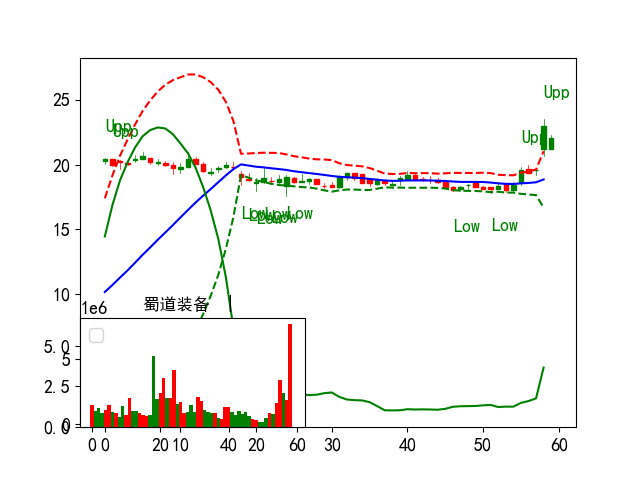

In [252]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio

In [253]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))

show_tdx_data(df_mask250[df_mask250.couts > 1][:20])
# show_tdx_data(df_mask250.loc[code_t])

(6347, 32)

count dd.couts
(code    date      
300863  2024-09-23    6
603000  2024-09-24    6
601336  2024-09-24    6
Name: couts, dtype: int64, (6031, 33))
compute percent
df_mask250:2711 df_mask_hmax:1696
cross_hamx:1624
Count:20 41


name  couts       date   perc  ra_diff  xratio      idx      hat  \
code                                                                        
399001      0      3 2024-09-30    NaN     1.32   43.49  2546.21  2484.69   
999999      0      3 2024-09-30    NaN     1.23    7.78   632.41   622.26   
600519   贵州茅台      2 2024-09-30   2.70     1.39    3.33   443.87   487.82   
300033    同花顺      5 2024-10-10 -10.92     0.00    3.01   106.17     0.00   
300896    爱美客      4 2024-10-10   1.64     0.00    2.53   100.45     0.00   
002371   北方华创      3 2024-10-10  -2.74     0.00    1.27    99.22     0.00   
300760   迈瑞医疗      3 2024-10-10   4.09     0.00    1.35    80.73     0.00   
300757   罗博特科      5 2024-10-10   3.71     0.00    1.59    75.92     0.00   
300750   宁德时代      5 2024-10-10   2.28     0.00    2.16    74.41     0.00   
600809   山西汾酒      3 2024-09-30   2.69     1.48    0.37    68.69    68.16   
000596   古井贡酒      3 2024-10-10   1.95     0.00    0.42    64.27     0.00   
600436    片仔癀      4 2024-10-10   4.22     0.00    1.40    63.39     0.00   
002594    比亚迪      4 2024-10-10   4.20     0.00    2.21    60.11     0.00   
603444    吉比特      3 2024-10-10   3.29     0.00    2.07    56.91     0.00   
000858  五 粮 液      3 2024-09-30   4.21     1.51    0.72    53.31    53.35   
300308   中际旭创      5 2024-10-10  -0.45     0.00    1.63    52.01     0.00   
300782    卓胜微      3 2024-10-10  -6.06     0.00    0.82    51.08     0.00   
000568   泸州老窖      4 2024-10-10   4.12     0.00    0.67    48.98     0.00   
605499   东鹏饮料      2 2024-09-30   4.85     1.34    0.49    46.87    42.24   
300502    新易盛      4 2024-10-10  -1.68     0.00    1.38    46.43     0.00   

             close  volsum5d  ...    ma250   nclose      llow   vol1d  \
code                          ...                                       
399001  10529.7570   13482.1  ...  2453.53      NaN  9829.432   39.54   
999999   3336.4974     215.1  ...     0.00      NaN  3153.697  123.92   
600519   1638.1500     194.9  ...   352.93  1635.92  1652.000   78.90   
300033    205.7600     -81.8  ...     0.00   205.07   185.000 -100.00   
300896    234.5000      53.2  ...     0.00   234.90   230.510 -100.00   
002371    393.9000     -54.9  ...     0.00   396.75   385.800 -100.00   
300760    308.8000     -36.4  ...     0.00   307.11   301.710 -100.00   
300757    157.0000     -24.2  ...     0.00   156.70   145.000 -100.00   
300750    260.8100      30.9  ...     0.00   259.75   255.000 -100.00   
600809    213.3000     139.9  ...    46.27   211.69   208.020   24.85   
000596    204.8700     -99.7  ...     0.00   201.78   196.810 -100.00   
600436    256.8900      48.1  ...     0.00   254.51   247.000 -100.00   
002594    318.5400      37.3  ...     0.00   317.07   309.980 -100.00   
603444    247.9000      56.4  ...     0.00   246.79   241.840 -100.00   
000858    153.9000     224.0  ...    35.48   152.68   152.700   14.07   
300308    165.6500     -18.4  ...     0.00   165.74   162.440 -100.00   
300782    110.1800      38.8  ...     0.00   109.50    99.570 -100.00   
000568    149.0000     -71.7  ...     0.00   147.57   142.200 -100.00   
605499    220.1800     309.7  ...    65.88   221.64   252.760  242.78   
300502    146.0000     -13.8  ...     0.00   145.04   141.050 -100.00   

           vol2d   vol3d  vol4d   vol5d  perc3d  perc5d  
code                                                     
399001  13361.67   -1.54  21.99   60.48   23.33   30.26  
999999    -14.58    1.42  18.98   85.38   15.20   21.37  
600519     -9.62   31.54 -26.35  120.45   24.95   38.56  
300033    -38.29   39.17   0.00   17.34   53.28   79.03  
300896     26.88   74.80  36.81   14.76   43.33   60.09  
002371      0.54   39.58   7.77   -2.80   30.00   33.48  
300760      3.99   37.00  16.02    6.56   29.55   32.52  
300757     40.52    8.30 -18.93   45.88   66.28   85.16  
300750     30.18   97.75 -15.52   18.50   26.91   32.04  
600809     -1.46   19.43  -7.59  104.64   33.10   41.69  
000596    -

df_mask250:1393
399001 1.32
xratio:-5.92 ra_diff:1.32
code: 399001


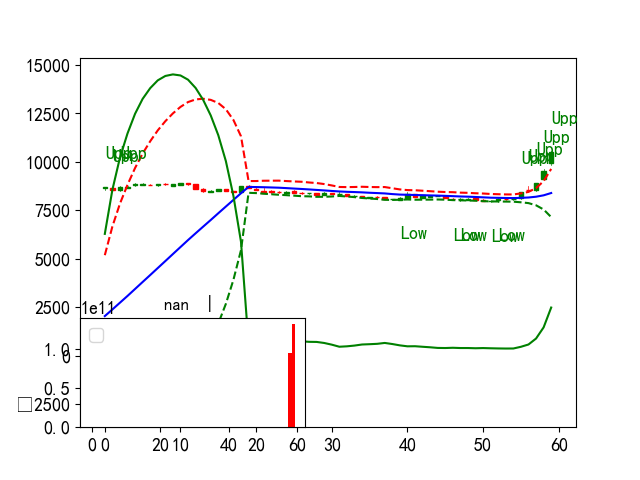

999999 1.23
xratio:-2.16 ra_diff:1.23
code: 999999


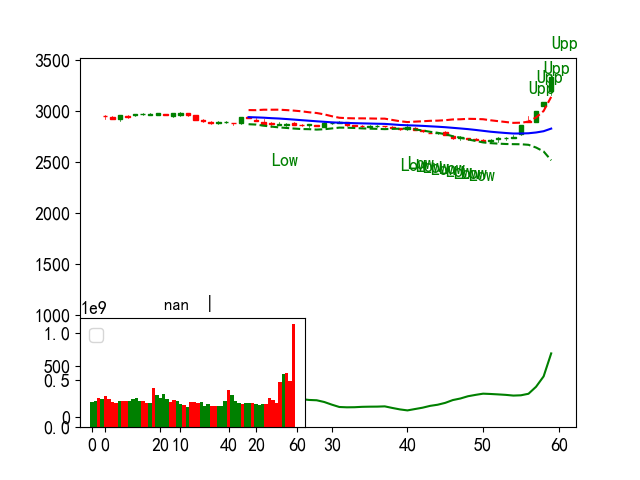

600519 0.0
xratio:-0.64 ra_diff:nan
code: 600519


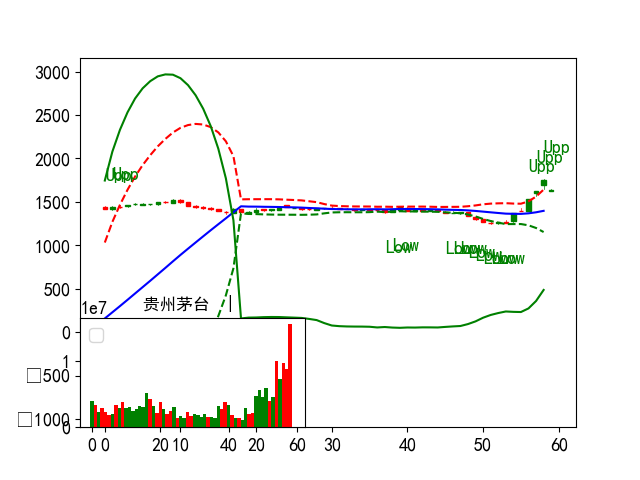

300033 0.0
xratio:0.55 ra_diff:nan
code: 300033


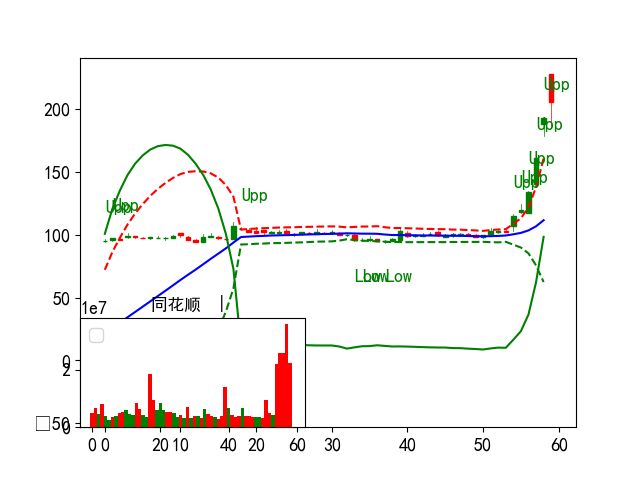

300896 0.0
xratio:-0.23 ra_diff:nan
code: 300896


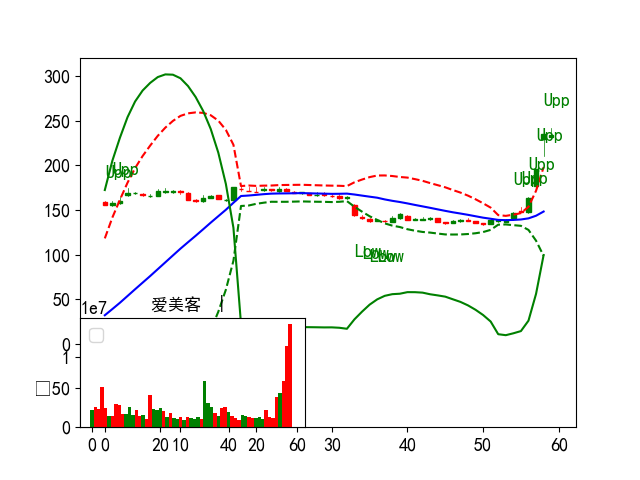

002371 0.0
xratio:-0.55 ra_diff:nan
code: 002371


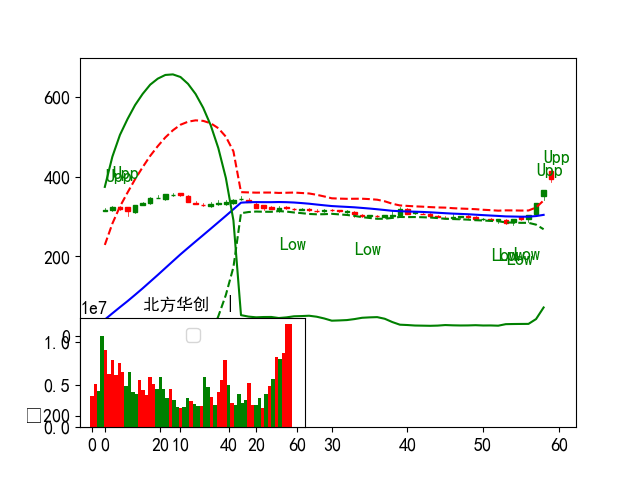

300760 0.0
xratio:-0.6 ra_diff:nan
code: 300760


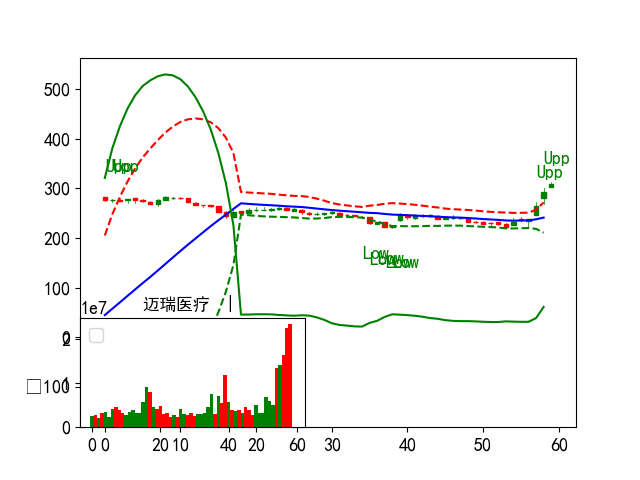

300757 0.0
xratio:0.09 ra_diff:nan
code: 300757


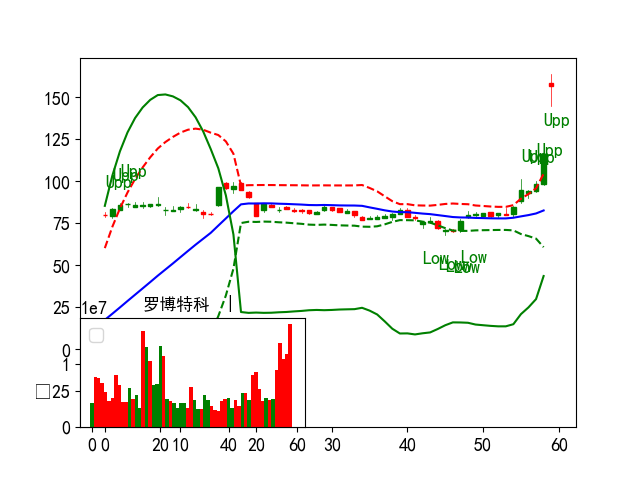

300750 0.0
xratio:0.48 ra_diff:nan
code: 300750


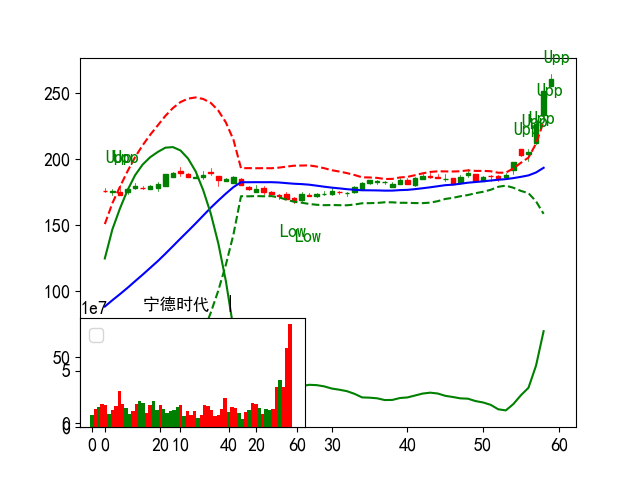

600809 0.0
xratio:-0.47 ra_diff:nan
code: 600809


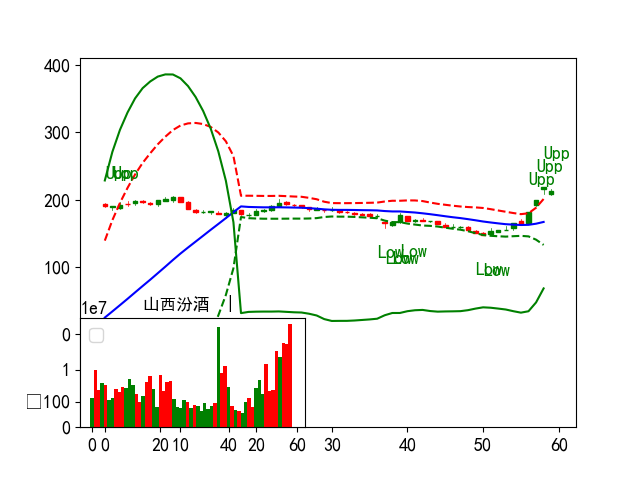

In [254]:
print("df_mask250:%s"%(len(df_mask250[df_mask250.couts > 1])))
for co in df_mask250[df_mask250.couts > 1].index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [255]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date      lopen       lhigh      llow       close           vol  \
code                                                                           
399001 2024-09-30  9950.6530  10556.9340  9829.432  10529.7570  1.324001e+11   
999999 2024-09-30  3194.7224   3358.5883  3153.697   3336.4974  1.102338e+09   

              amount  ra_diff     ma10      ma5  ...  xratio      idx  couts  \
code                                             ...                           
399001  1.425264e+12     1.32  8615.66  9186.94  ...   43.49  2546.21      3   
999999  1.167773e+12     1.23  2882.75  3036.88  ...    7.78   632.41      3   

        nclose  open  high  low  llastp  ticktime  perc  
code                                                     
399001     NaN   NaN   NaN  NaN     NaN       NaT   NaN  
999999     NaN   NaN   NaN  NaN     NaN       NaT   NaN  

[2 rows x 41 columns]

(497, 41)

In [256]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'
code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(2711, 41)  lastd:(1359, 41) 
code
300223     北京君正
300782      卓胜微
300226     上海钢联
300177      中海达
300142     沃森生物
301169     零点有数
300618     寒锐钴业
300672      国科微
300776     帝尔激光
300474      景嘉微
300613      富瀚微
300390     天华新能
300168     万达信息
300576     容大感光
300724     捷佳伟创
300316     晶盛机电
300122     智飞生物
300376    ST易事特
300759     康龙化成
301299     卓创资讯
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:1696
002423 0.0
xratio:0.03 ra_diff:nan
code: 002423


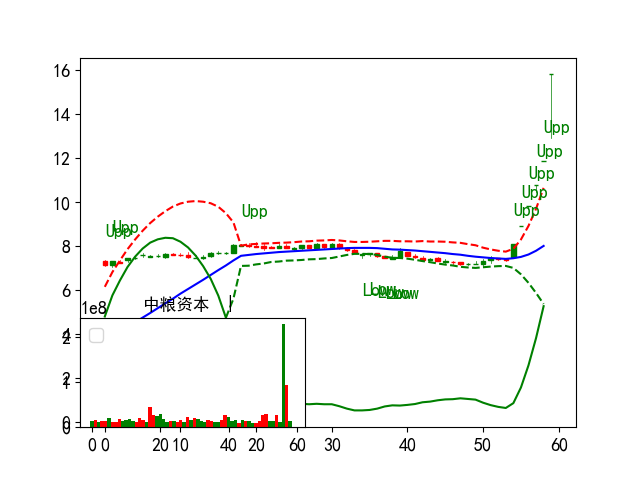

002693 0.0
xratio:0.13 ra_diff:nan
code: 002693


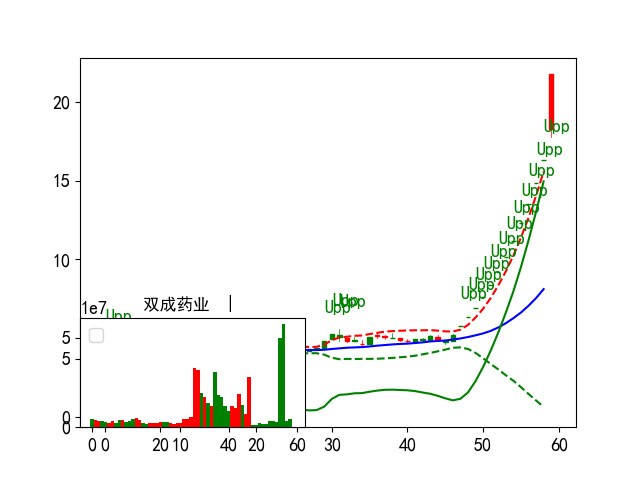

600705 0.0
xratio:0.01 ra_diff:nan
code: 600705


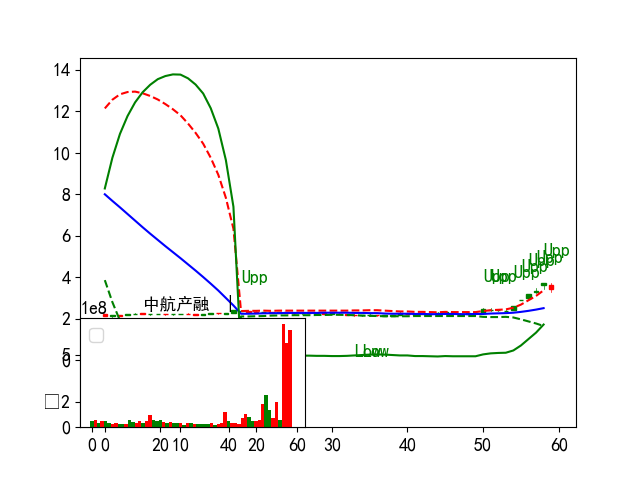

601162 0.0
xratio:0.02 ra_diff:nan
code: 601162


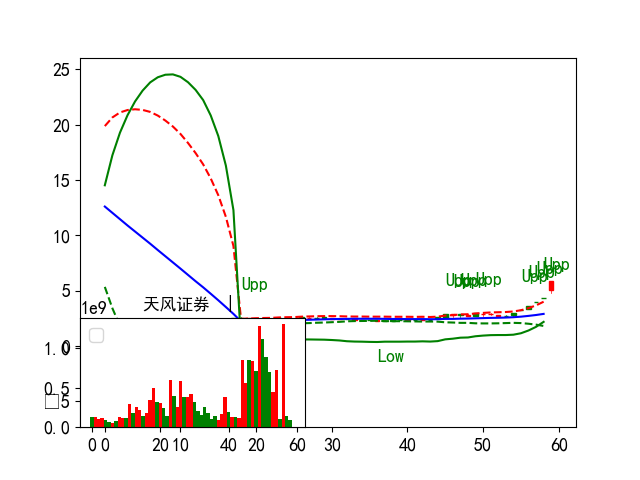

300140 0.0
xratio:-0.01 ra_diff:nan
code: 300140


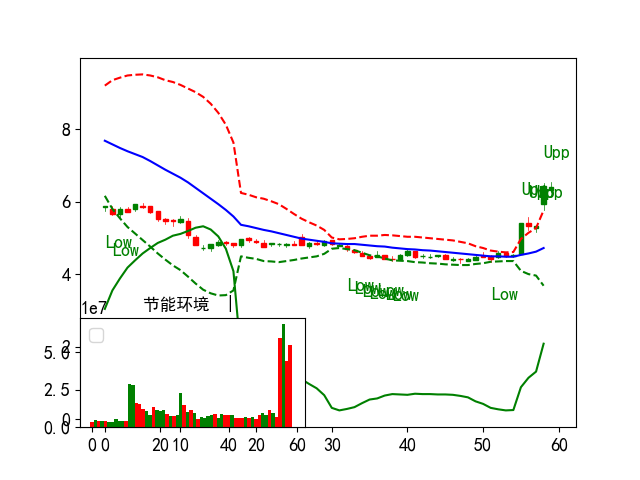

301109 0.0
xratio:0.0 ra_diff:nan
code: 301109


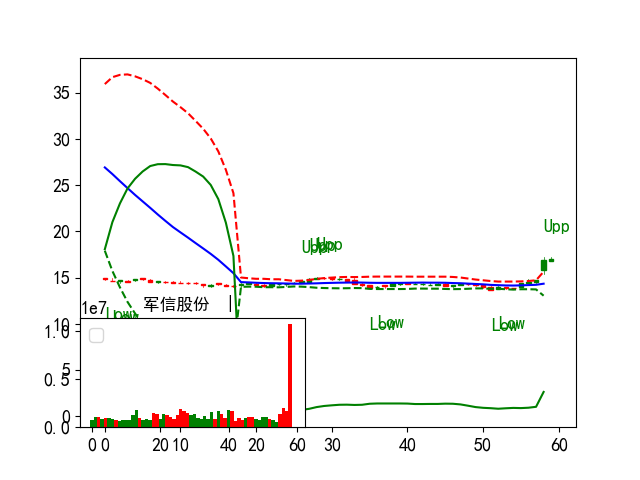

300834 0.0
xratio:-0.01 ra_diff:nan
code: 300834


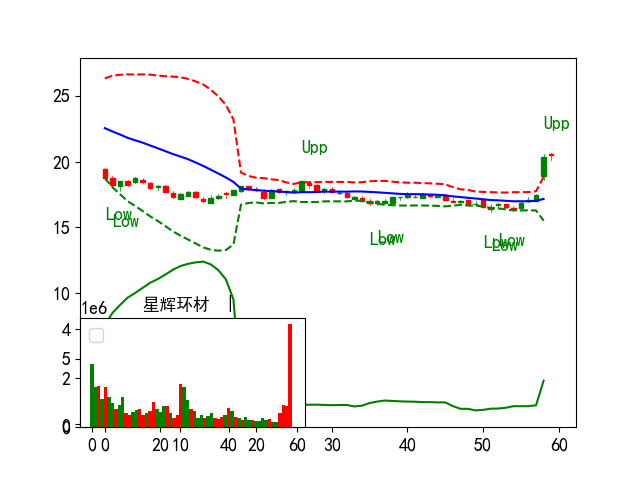

300390 0.0
xratio:0.02 ra_diff:nan
code: 300390


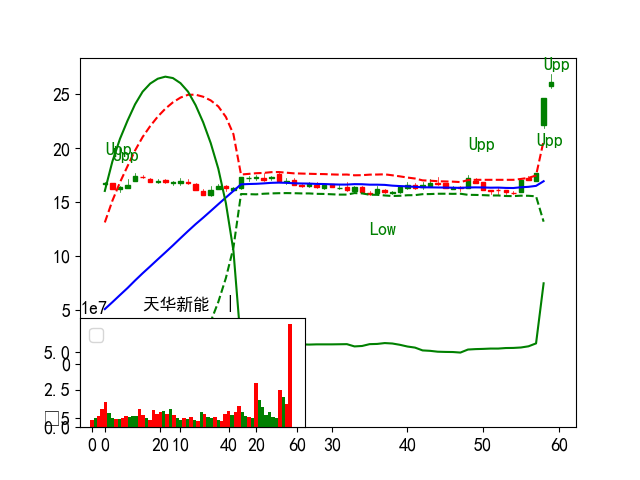

301377 0.0
xratio:-0.03 ra_diff:nan
code: 301377


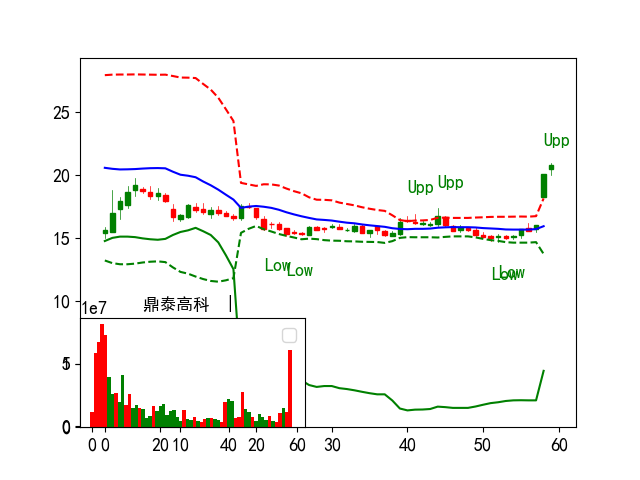

300259 0.0
xratio:0.0 ra_diff:nan
code: 300259


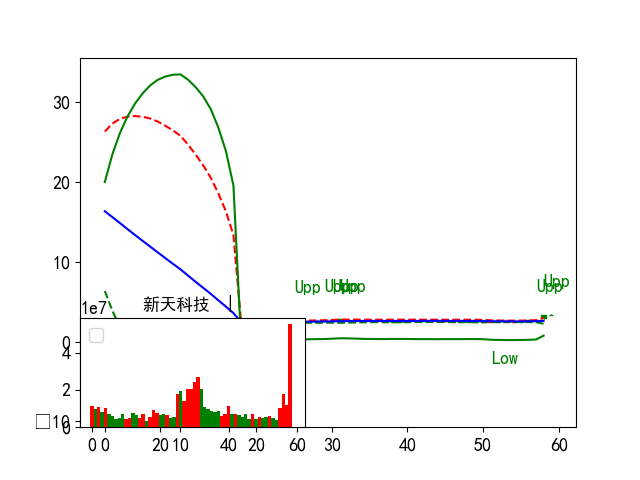

In [257]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:1359
300223 0.0
xratio:-0.17 ra_diff:nan
code: 300223


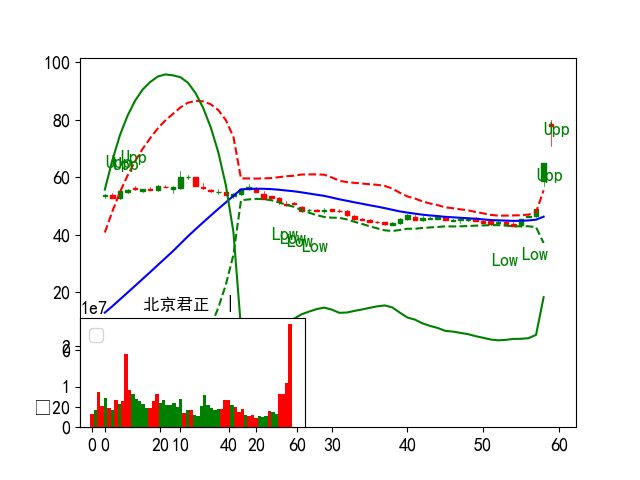

300782 0.0
xratio:-0.15 ra_diff:nan
code: 300782


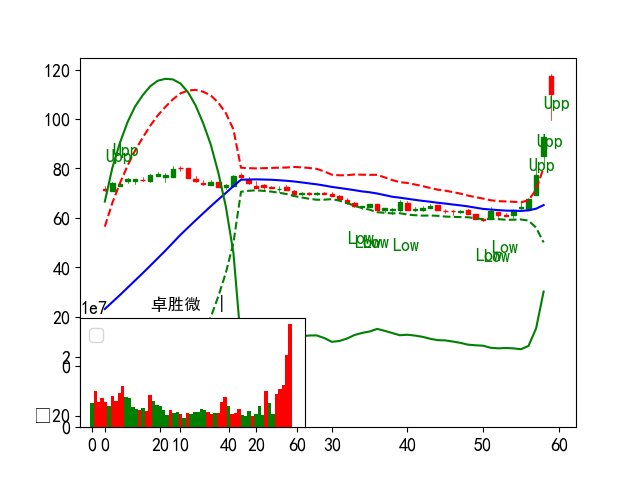

300226 0.0
xratio:0.02 ra_diff:nan
code: 300226


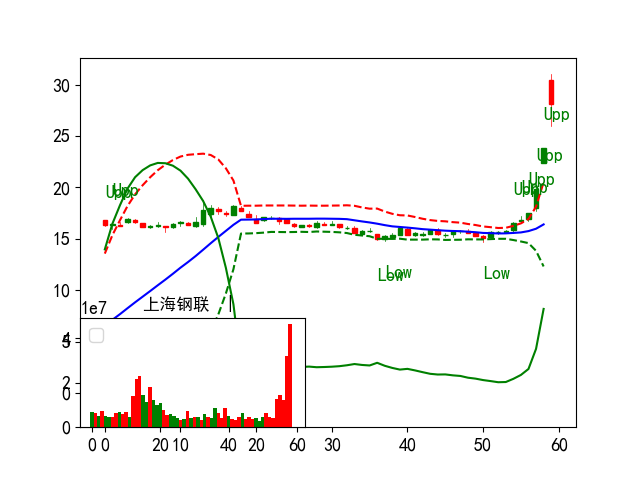

300177 0.0
xratio:0.01 ra_diff:nan
code: 300177


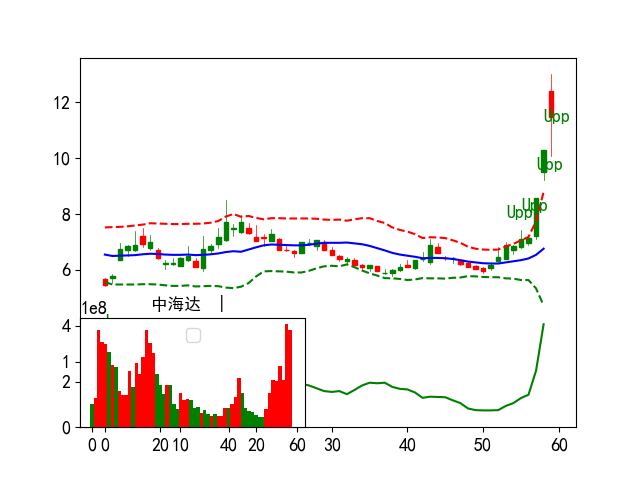

300142 0.0
xratio:-0.0 ra_diff:nan
code: 300142


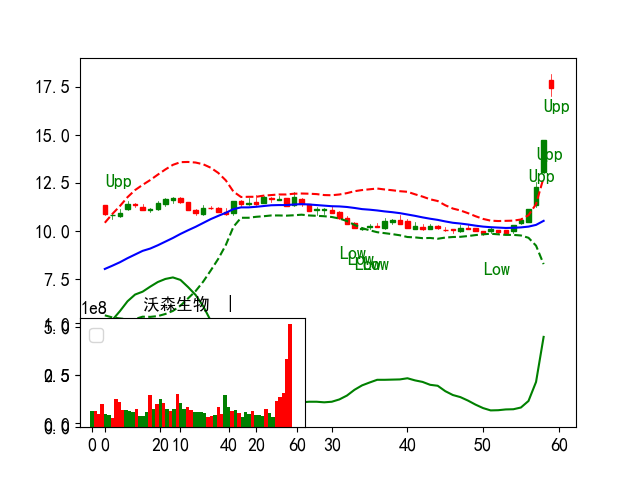

301169 0.0
xratio:0.04 ra_diff:nan
code: 301169


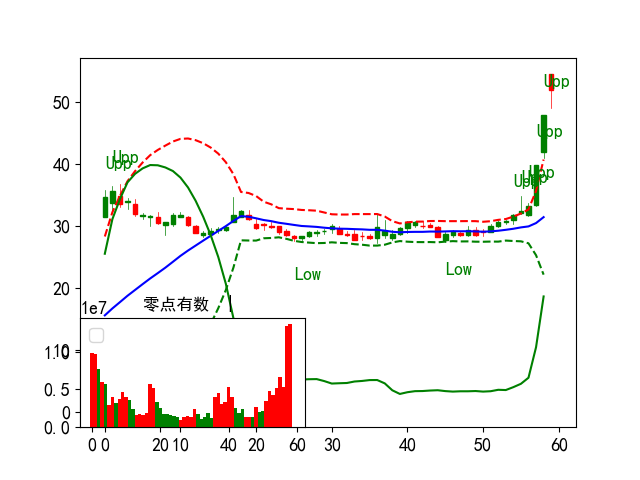

300618 0.0
xratio:-0.04 ra_diff:nan
code: 300618


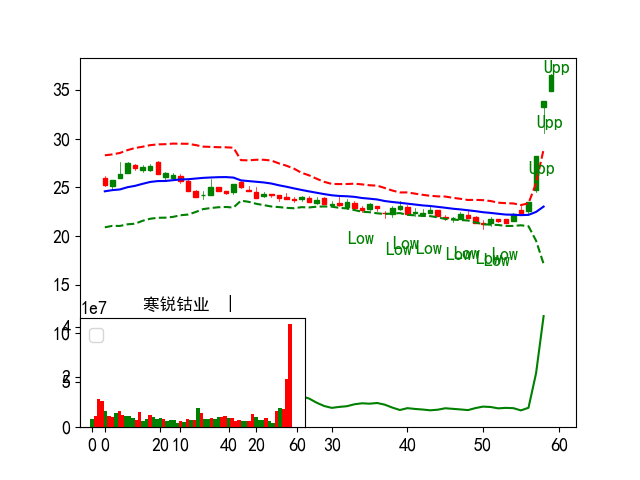

300672 0.0
xratio:-0.14 ra_diff:nan
code: 300672


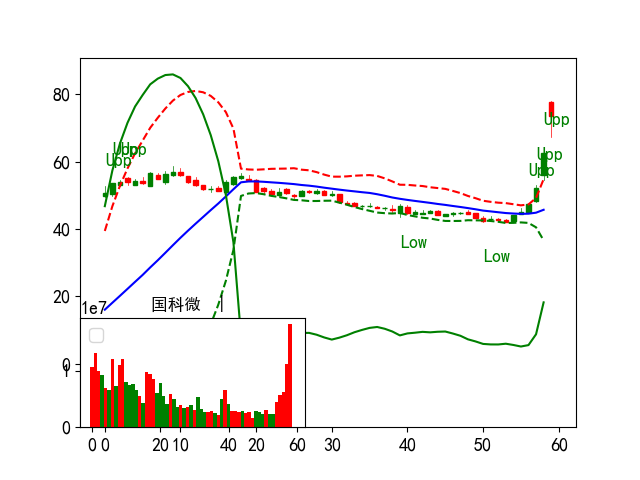

300776 0.0
xratio:-0.04 ra_diff:nan
code: 300776


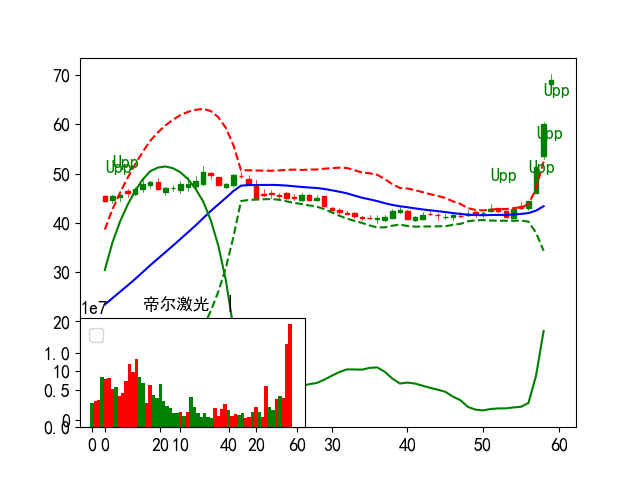

300474 0.0
xratio:-0.11 ra_diff:nan
code: 300474


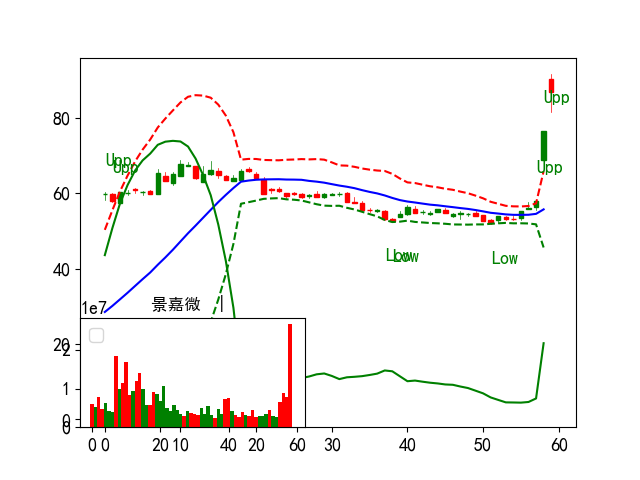

In [258]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [259]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250][:5])

cross_hamx:1110
Count:5 41


name  couts       date  perc  ra_diff  xratio    idx  hat   close  \
code                                                                        
300223  北京君正      3 2024-10-10 -1.34      0.0    0.53  33.60  0.0   77.60   
300782   卓胜微      3 2024-10-10 -6.06      0.0    0.82  51.08  0.0  110.18   
300226  上海钢联      5 2024-10-10 -2.47      0.0    0.27  12.98  0.0   28.08   
300177   中海达      3 2024-10-10 -7.96      0.0    0.13   5.47  0.0   11.45   
300142  沃森生物      4 2024-10-10 -0.29      0.0    0.13   7.53  0.0   17.43   

        volsum5d  ...  ma250  nclose   llow  vol1d   vol2d   vol3d  vol4d  \
code              ...                                                       
300223     216.2  ...    0.0   75.80  70.64 -100.0  132.63   35.59  -0.46   
300782      38.8  ...    0.0  109.50  99.57 -100.0   43.15   72.22   8.72   
300226     103.3  ...    0.0   27.93  26.00 -100.0   45.42  157.76 -14.47   
300177      23.1  ...    0.0   11.50  10.06 -100.0   -6.54  120.30 -22.79   
300142      77.9  ...    0.0   17.46  17.00 -100.0   52.34   98.76  11.68   

         vol5d  perc3d  perc5d  
code                            
300223  148.42   67.28   80.09  
300782   14.68   62.41   73.81  
300226   14.60   60.46   69.87  
300177   32.09   60.36   67.40  
300142   15.16   56.74   69.06  

[5 rows x 24 columns]

df_mask250:1110
601366 0.0
xratio:0.0 ra_diff:nan
code: 601366


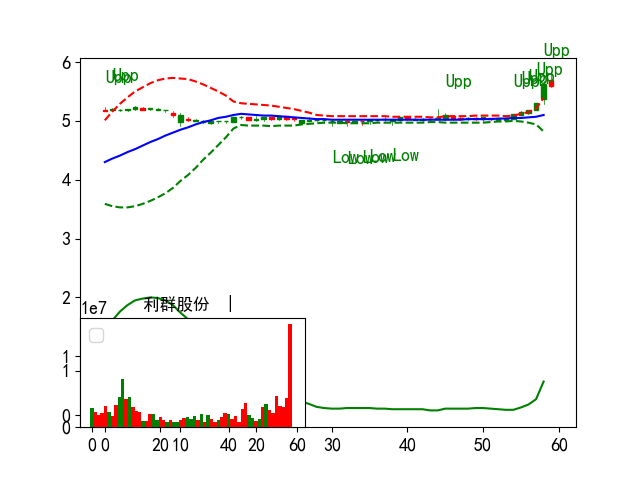

600690 0.0
xratio:0.04 ra_diff:nan
code: 600690


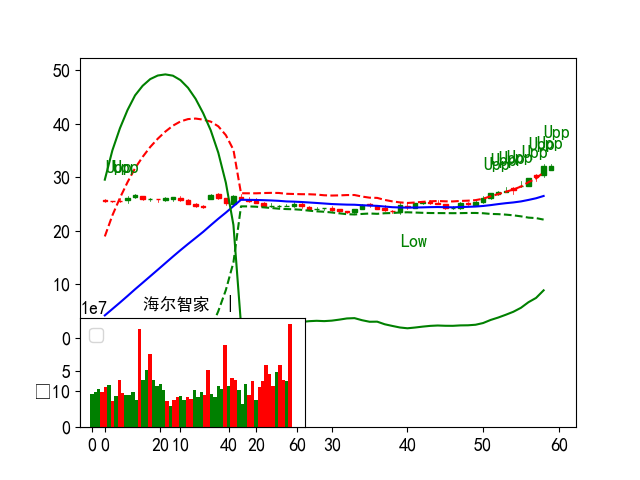

600406 0.0
xratio:0.04 ra_diff:nan
code: 600406


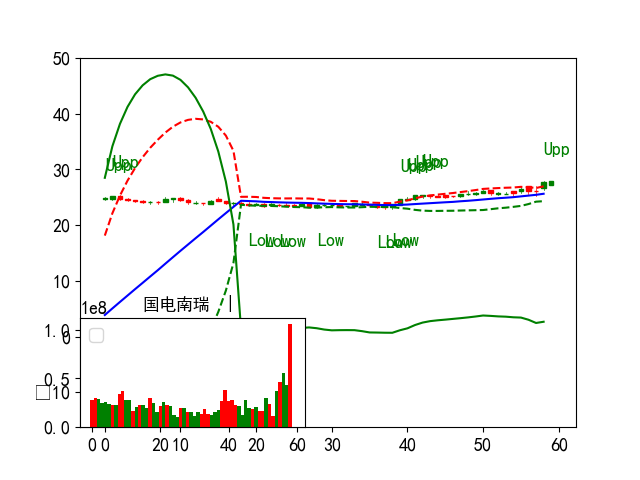

601607 0.0
xratio:0.01 ra_diff:nan
code: 601607


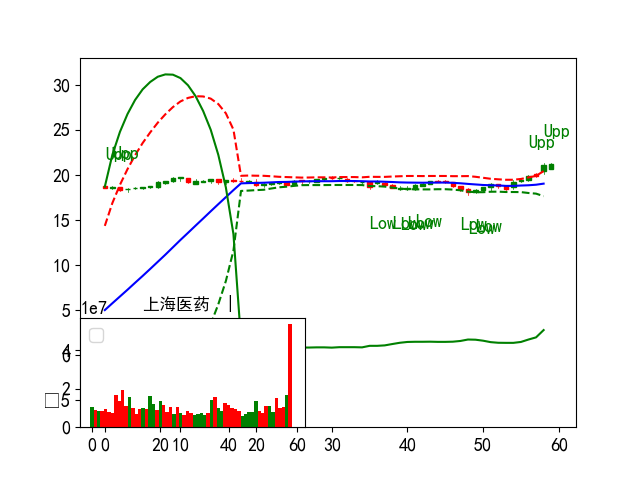

600415 0.0
xratio:0.03 ra_diff:nan
code: 600415


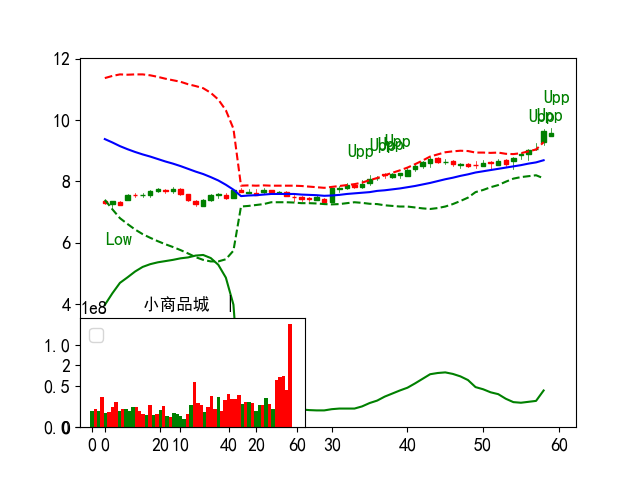

000333 0.0
xratio:0.11 ra_diff:nan
code: 000333


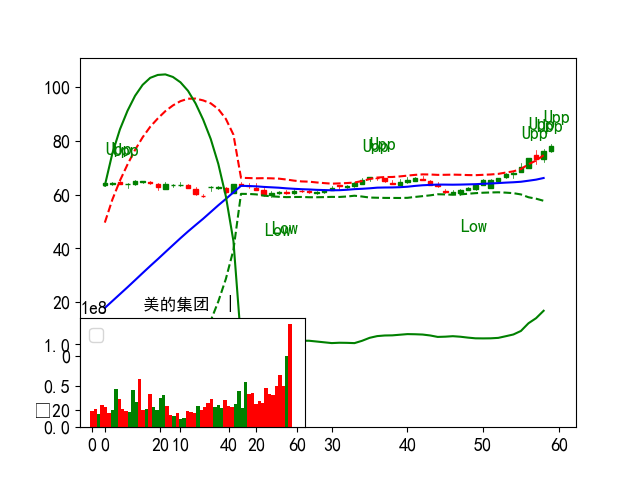

002951 0.0
xratio:0.03 ra_diff:nan
code: 002951


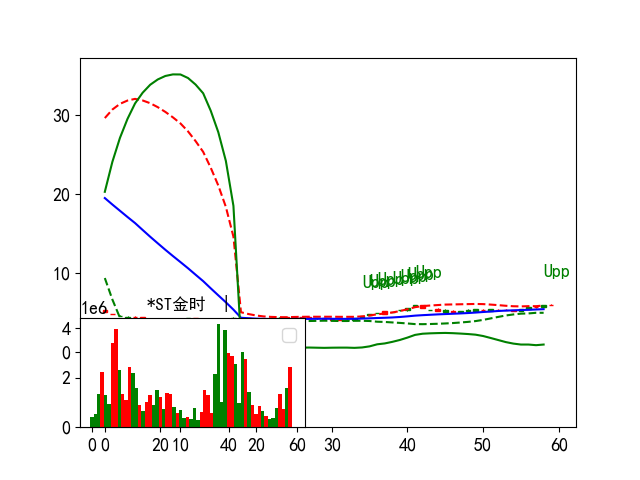

601166 0.0
xratio:0.01 ra_diff:nan
code: 601166


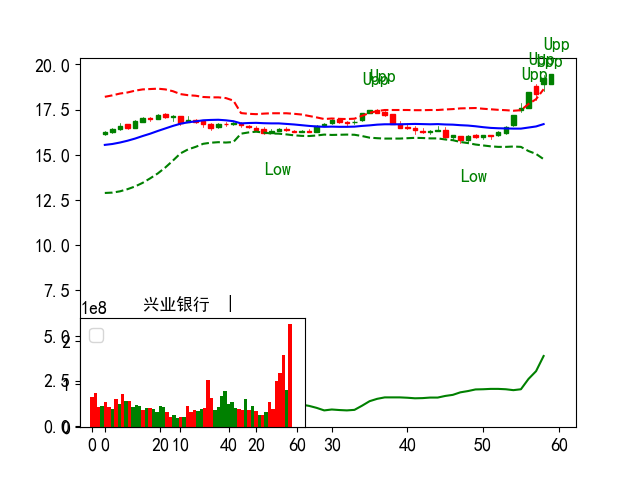

600287 0.0
xratio:0.0 ra_diff:nan
code: 600287


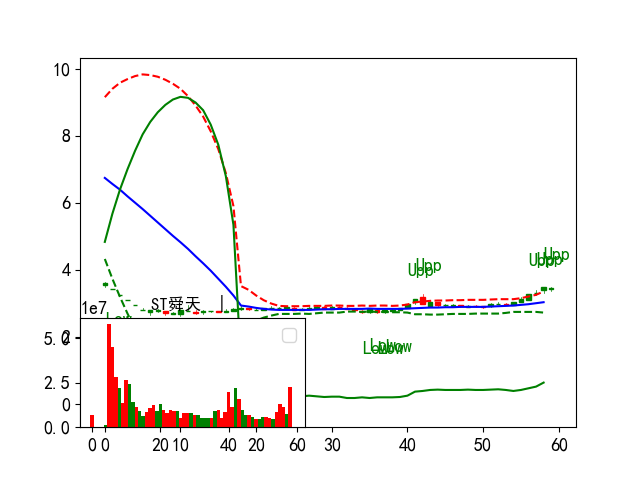

600000 0.0
xratio:0.01 ra_diff:nan
code: 600000


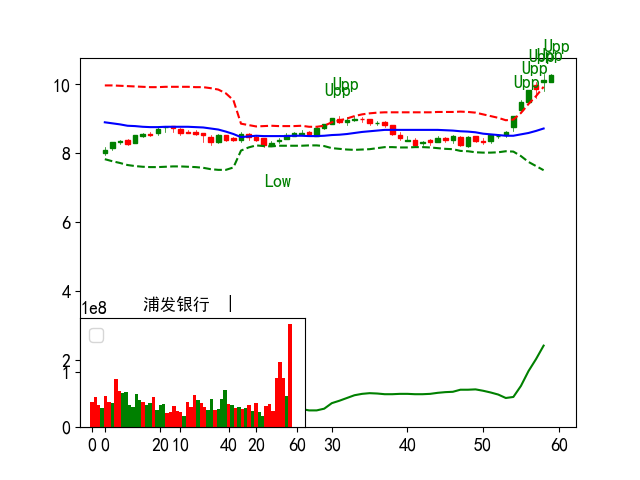

In [260]:
print("df_mask250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [261]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [262]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [263]:
top_temp.shape
top_temp.index

(1296, 34)

Index(['002625', '603737', '601601', '601318', '601179', '603596', '603668',
       '601066', '301236', '601633',
       ...
       '300842', '300833', '002932', '300174', '002880', '000733', '001309',
       '001298', '001259', '601666'],
      dtype='object', name='code', length=1296)

## plt.close('all')

In [264]:
# plt.close('all')

# 写入060